<a href="https://colab.research.google.com/github/plaban1981/Haystack_NLP/blob/main/Haystack_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is Haystack?


**Haystack** is an open-source framework for building search systems that work intelligently over large document collections.

* Recent advances in NLP have enabled the application of question answering, retrieval and summarization to real world settings and **Haystack is designed to be the bridge between research and industry**

* Latest NLP models: Utilize all transformer based models (BERT, RoBERTa, MiniLM, DPR ...) and smoothly switch when new ones get published
* Flexible databases: Load data into and query from a range of databases such as Elasticsearch, Milvus, FAISS, SQL and more
* Scalability: Production-ready deployments that scale to millions of documents
* End-to-End: All tooling you need to implement, evaluate, improve and run a search system
* Domain adaptation: Fine-tune models to your own domain & improve them continuously via user feedback

## Retriever-Reader

* The most common system built with Haystack is the Retriever-Reader Pipeline 

* it is designed to optimize for both speed and performance on the task of Open Domain Question Answering. 

* In practice, this is a great back bone for creating a search system that can handle detailed full sentence queries.

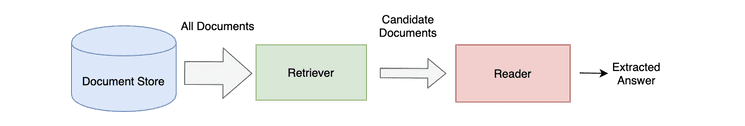

## Readers 

* Readers, also known as Open-Domain QA systems in Machine Learning speak, are powerful models that do close analysis of documents and perform the core task of question answering. 

* The Readers in Haystack are trained from the latest transformer based language models and can be significantly sped up using GPU acceleration. 

* However, it is not currently feasible to use the Reader directly on large collection of documents.

## Retriever

* The Retriever assists the Reader by acting as a lightweight filter that reduces the number of documents that the Reader has to process. 

It does this by:

  * Scanning through all documents in the database
  * Quickly identifying the relevant and dismissing the irrelevant
  * Passing on only a small candidate set of documents to the Reader

Current methods fall into one of the two categories:

* sparse

      - keyword based
      - fast indexing and querying
      - e.g. BM25
      
* dense

      - neural network based
      - computationally heavy indexing but fast querying
      - e.g. Dense Passage Retrieval
    


## Installation

In [1]:
pip install farm-haystack


     |████████████████████████████████| 180 kB 8.4 MB/s 
     |████████████████████████████████| 52 kB 778 kB/s 
     |████████████████████████████████| 3.4 MB 49.8 MB/s 
     |████████████████████████████████| 332 kB 50.3 MB/s 
     |████████████████████████████████| 402 kB 52.2 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 3.8 MB 37.8 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 8.4 MB 30.7 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 981 kB 58.4 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 321 kB 55.4 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 204 kB 46.4 MB/s 
     |████████████████████████████████| 100 kB 8.6 MB/s 
     |████████████████████████

## Use cases - How to index Question and Answer Data with Haystack and Elasticsearch
https://haystack.deepset.ai/docs/latest/use_casesmd

## Input data

In [2]:
!wget "https://raw.githubusercontent.com/jamescalam/aurelius/main/data/meditations.txt"

--2021-09-11 14:34:29--  https://raw.githubusercontent.com/jamescalam/aurelius/main/data/meditations.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241388 (236K) [text/plain]
Saving to: ‘meditations.txt’

meditations.txt     100%[===================>] 235.73K  --.-KB/s    in 0.02s   

2021-09-11 14:34:29 (12.3 MB/s) - ‘meditations.txt’ saved [241388/241388]



## Start an Elasticsearch server

* manually download and execute Elasticsearch from source

In [7]:
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                    stdout=PIPE, stderr=STDOUT,
                    preexec_fn=lambda: os.setuid(1)  # as daemon
                   )
# wait until ES has started
! sleep 30

##Check for indices if any existingdata is present 

In [8]:
import requests
requests.get("http://localhost:9200/_cat/indices").text

''

In [18]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
doc_store = ElasticsearchDocumentStore(host='localhost',
                                       username='',
                                       password = '',
                                       index ='new')

09/11/2021 15:37:24 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.006s]
09/11/2021 15:37:25 - INFO - elasticsearch -   PUT http://localhost:9200/new [status:200 request:0.203s]
09/11/2021 15:37:25 - INFO - elasticsearch -   HEAD http://localhost:9200/label [status:200 request:0.006s]


## Loading Documents into the DocumentStore

In [10]:
with open("/content/meditations.txt","r") as f:
  data = f.read()

In [11]:
data[:100]

'From my grandfather Verus I learned good morals and the government of my temper.\nFrom the reputation'

In [12]:
data = data.split("\n")
len(data)

508

* In Haystack, DocumentStores expect Documents in a dictionary format.
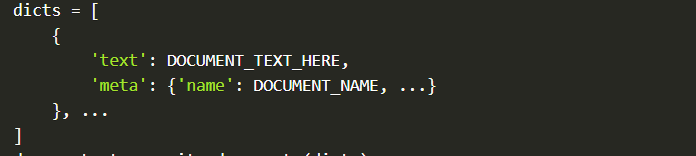

## Modify data in correct format for storing in Elastic Document Store

In [13]:
data_json = [{'text':paragraph,'meta':{'source':'meditation'}} for paragraph in data]

In [16]:
len(data_json)

508

In [15]:
data_json[:10]

[{'meta': {'source': 'meditation'},
  'text': 'From my grandfather Verus I learned good morals and the government of my temper.'},
 {'meta': {'source': 'meditation'},
  'text': 'From the reputation and remembrance of my father, modesty and a manly character.'},
 {'meta': {'source': 'meditation'},
  'text': 'From my mother, piety and beneficence, and abstinence, not only from evil deeds, but even from evil thoughts; and further, simplicity in my way of living, far removed from the habits of the rich.'},
 {'meta': {'source': 'meditation'},
  'text': 'From my great-grandfather, not to have frequented public schools, and to have had good teachers at home, and to know that on such things a man should spend liberally.'},
 {'meta': {'source': 'meditation'},
  'text': "From my governor, to be neither of the green nor of the blue party at the games in the Circus, nor a partizan either of the Parmularius or the Scutarius at the gladiators' fights; from him too I learned endurance of labour, and 

## Store data into document store

In [19]:
doc_store.write_documents(data_json)
requests.get("http://localhost:9200/new/_count").json()

09/11/2021 15:38:12 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:0.434s]
09/11/2021 15:38:13 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.003s]


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'count': 508}

## Initalize Retriever, Reader, & Pipeline

## Retriever : Interacts with the DocumentStore

In [22]:
from haystack.retriever.sparse import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=doc_store)

## Reader : semantically extract information from documents instead of plain lexical search. 

* Reader models are generally built by adding a Question Answering Head on Language Models like BERT.

In [23]:
from haystack.reader import FARMReader
#question and content encoder model from huggingface library
reader = FARMReader(model_name_or_path='deepset/bert-base-cased-squad2')

09/11/2021 16:10:40 - INFO - farm.utils -   Using device: CUDA 
09/11/2021 16:10:40 - INFO - farm.utils -   Number of GPUs: 1
09/11/2021 16:10:40 - INFO - farm.utils -   Distributed Training: False
09/11/2021 16:10:40 - INFO - farm.utils -   Automatic Mixed Precision: None
09/11/2021 16:10:40 - INFO - filelock -   Lock 140015621446096 acquired on /root/.cache/huggingface/transformers/15cc42d3f2accfabf2128048289832150b75adafd7ab2b50e37a998b71c528b4.250bb3d860b46cc2180effc9227c0d2faf19405a1585c714c721dcc1a1d04727.lock


Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

09/11/2021 16:10:41 - INFO - filelock -   Lock 140015621446096 released on /root/.cache/huggingface/transformers/15cc42d3f2accfabf2128048289832150b75adafd7ab2b50e37a998b71c528b4.250bb3d860b46cc2180effc9227c0d2faf19405a1585c714c721dcc1a1d04727.lock
09/11/2021 16:10:41 - INFO - filelock -   Lock 140015624775056 acquired on /root/.cache/huggingface/transformers/4fb91611eb90525e5d3e1dc48e72a8c8a9d19f8bb138af51f0795a020acf8bfa.eb6109ce49f42129661193e04ce291fda8ccb3407daa60a09d011e671c60a188.lock


Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

09/11/2021 16:10:53 - INFO - filelock -   Lock 140015624775056 released on /root/.cache/huggingface/transformers/4fb91611eb90525e5d3e1dc48e72a8c8a9d19f8bb138af51f0795a020acf8bfa.eb6109ce49f42129661193e04ce291fda8ccb3407daa60a09d011e671c60a188.lock
Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
09/11/2021 16:11:00 - INFO - filelock -   Lock 140015621269776 acquired on /root/.cache/huggingface/transformers/a027c4e547fd30e501f9edb04ed6401

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

09/11/2021 16:11:01 - INFO - filelock -   Lock 140015621269776 released on /root/.cache/huggingface/transformers/a027c4e547fd30e501f9edb04ed6401edefe7eede664b9528d4babaf78d1bda6.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
09/11/2021 16:11:02 - INFO - filelock -   Lock 140015621595472 acquired on /root/.cache/huggingface/transformers/5fa07cc35cf92053100af63a5b23424ba428c75dafc83de837f7c2bd5118a8b1.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

09/11/2021 16:11:02 - INFO - filelock -   Lock 140015621595472 released on /root/.cache/huggingface/transformers/5fa07cc35cf92053100af63a5b23424ba428c75dafc83de837f7c2bd5118a8b1.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock
09/11/2021 16:11:02 - INFO - filelock -   Lock 140015471390416 acquired on /root/.cache/huggingface/transformers/8d45cf43007a2f83a66ff292adf10e02ae1859acd064791f6b6417f7e528b1f3.3e813ef7b46a58d7e35c90b0aacc2127a3800bba6bff791af1651012cf2fab11.lock


Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

09/11/2021 16:11:02 - INFO - filelock -   Lock 140015471390416 released on /root/.cache/huggingface/transformers/8d45cf43007a2f83a66ff292adf10e02ae1859acd064791f6b6417f7e528b1f3.3e813ef7b46a58d7e35c90b0aacc2127a3800bba6bff791af1651012cf2fab11.lock
09/11/2021 16:11:03 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
09/11/2021 16:11:03 - INFO - farm.utils -   Using device: CUDA 
09/11/2021 16:11:03 - INFO - farm.utils -   Number of GPUs: 1
09/11/2021 16:11:03 - INFO - farm.utils -   Distributed Training: False
09/11/2021 16:11:03 - INFO - farm.utils -   Automatic Mixed Precision: None
09/11/2021 16:11:03 - INFO - farm.infer -   Got ya 3 parallel workers to do inference ...
09/11/2021 16:11:03 - INFO - farm.infer -    0    0    0 
09/11/2021 16:11:03 - INFO - farm.infer -   /w\  /w\  /w\
09/11/2021 16:11:03 - INFO - farm.infer -   /'\  / \  /'\
09/11/2021 16:11:03 - INFO - farm.infer -       


## Running Search Queries

There are many different flavours of search that can be created using Haystack. But to give just one example of what can be achieved, let's look more closely at an **Open Domain Question Answering (ODQA) Pipeline**.

Querying in an ODQA system involves searching for an answer to a given question within the full document store. This process will:

* make the Retriever filter for a small set of relevant candidate documents
* get the Reader to process this set of candidate documents
* return potential answers to the given question



==> Usually, there are tight time constraints on querying and so it needs to be a lightweight operation. 

==> When documents are loaded, **Haystack will precompute any of the results that might be useful at query time.**

==> In Haystack, **querying is performed with a Pipeline object which connects the reader to the retriever**.

In [24]:
from haystack.pipeline import ExtractiveQAPipeline
pipeline = ExtractiveQAPipeline(reader = reader,
                                retriever = retriever)

In [25]:
answers = pipeline.run(query='What did you learn from grandfather',top_k_retriever=10, top_k_reader=5)

09/11/2021 16:14:56 - INFO - elasticsearch -   POST http://localhost:9200/new/_search [status:200 request:0.068s]
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 54.27 Batches/s]


In [27]:
from haystack.utils import print_answers
print_answers(answers, details="minimal")

[   {   'answer': 'not to have frequented public schools, and to have had good '
                  'teachers at home, and to know that on such things a man '
                  'should spend liberally.',
        'context': 'andfather, not to have frequented public schools, and to '
                   'have had good teachers at home, and to know that on such '
                   'things a man should spend liberally.'},
    {   'answer': 'good morals and the government of my temper.',
        'context': 'From my grandfather Verus I learned good morals and the '
                   'government of my temper.'},
    {   'answer': 'a man must learn a great deal to enable him to pass a '
                  "correct judgement on another man's acts",
        'context': 'ith a certain reference to circumstances. And in short, a '
                   'man must learn a great deal to enable him to pass a '
                   "correct judgement on another man's acts."},
    {   'answer': 'self-governmen